In [1]:
import jax
import jax.numpy as jnp
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from LombScargle import periodogram
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('../img/style.mplstyle')




def randomized_period(y):
    """null template with randomized period
        num: the number of random periods to be generated. Should be larger than T / minimal period that will be later used with the template
        spread = b/a"""
    
    #y = jax.random.gamma(key, concentration, (num, ))    
    
    def get_periods(freq, total_time):
        """Convert the y to the periods of cycles.
            cycles is a float = freq * total time"""
        cycles= freq * total_time
        cycles_frac, _cycles_integer = jnp.modf(cycles)
        cycles_integer = _cycles_integer.astype(int)

        weights = (jnp.arange(1, len(y)+1) <= cycles).astype(float)  
        weights = weights.at[cycles_integer].set(cycles_frac)
        return total_time * y / jnp.sum(y * weights)


    def temp(_t, freq):
        t = _t - jnp.min(_t)
        periods = get_periods(freq, jnp.max(t)) 
        grid = jnp.cumsum(periods)
        grid_paddled = jnp.insert(grid, 0, 0.)
        which_period = jnp.searchsorted(grid, t)
        x = (t - grid_paddled[which_period]) / periods[which_period]
        return jnp.sin(2 * jnp.pi * x), jnp.cos(2 * jnp.pi * x)
    
    return temp


def uniform(key, spread, num_reps, cycles):
    num = (int)(cycles + 1)
    return jax.random.uniform(key, shape= (num_reps, num), minval= 1., maxval= spread)  
    
    
def mainn(y, cycles):
    """period = 1, phase = 0, without loss of generality"""
    
    # data = unmodified template
    time = jnp.linspace(0, cycles, (int)(cycles * 20))
    data = jnp.sin(2 * jnp.pi * time)
    c= jnp.log10(5.)
    freq = jnp.logspace(-c, c, 1000)
    
    # scan with the modified template
    temp = randomized_period(y)
    periodogram_modified = periodogram.lomb_scargle(time, data, floating_mean= False, temp_func= temp)
    score_modified = jnp.max(jax.vmap(periodogram_modified)(freq)[0])

    score_og = periodogram.lomb_scargle(time, data, floating_mean= False)(1.)[0]
    
    return score_modified / score_og

vmainn = jax.vmap(mainn, (0, None))

def main(cycles, spread):
    key = jax.random.key(42)
    y = uniform(key, spread, 500, cycles)
    return vmainn(y, cycles)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


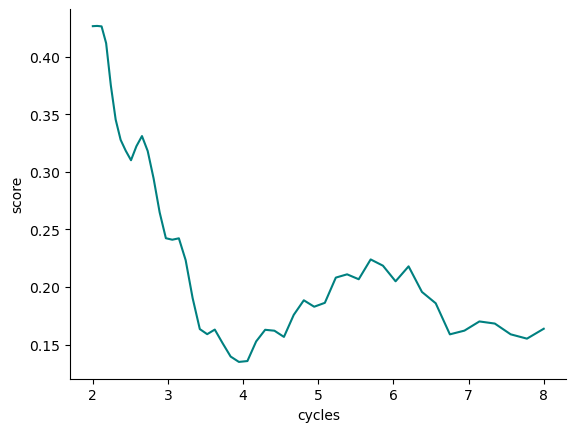

In [2]:
y = jnp.array([1.0, 0.28994229435920715, 0.14481185376644135, 0.2643081545829773, 0.3739936947822571, 0.310786634683609, 0.20970465242862701, 0.18679137527942657, 0.1289890557527542, 0.10473709553480148, 9.999999046325684, 0.16638170182704926, 0.3570786118507385, 0.2146141231060028, 0.14481185376644135, 0.1289890557527542, 0.10718914866447449, 0.1175849586725235, 0.12033779919147491, 0.10000001639127731, 0.20970465242862701, 0.10473709553480148, 8.907352447509766, 0.651733934879303, 0.2523539364337921, 0.23542864620685577, 0.1625755876302719, 0.20490749180316925, 0.1260382980108261, 0.12315507233142853, 0.1175849586725235, 0.10718914866447449, 0.1023411676287651, 0.15167170763015747, 0.10473709553480148, 0.10473709553480148, 7.752595901489258, 0.42970046401023865, 0.16638170182704926, 0.15885652601718903, 0.1414991319179535, 0.15885652601718903, 0.1482020765542984, 0.10718914866447449, 0.14481185376644135, 0.13200883567333221, 0.12033779919147491, 0.5672425627708435, 0.3489101231098175, 0.23004302382469177, 0.2704960107803345])

c = np.logspace(np.log10(2.), jnp.log10(8), 50)
s = np.array([mainn(y, cc) for cc in c])
plt.plot(c, s)
plt.xlabel('cycles')
plt.ylabel('score')
plt.show()

In [ ]:
params = [[10, 3], [100, 3], [10, 10]]
r = np.array([main(*param) for param in params])

In [ ]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
for i in range(len(params)):
    plt.hist(r[i], bins = 20, density= True, alpha = 0.5, label= 'cycles = {0}, b/a = {1}'.format(*params[i]))

plt.xlabel('score(modified) / score(periodic)')
plt.ylabel('density')
plt.xlim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(params)):
    plt.hist(r[i], bins = 2000, density= True, cumulative = -1, histtype= 'step', label= 'cycles = {0}, b/a = {1}'.format(*params[i]), lw = 2)

plt.xlabel('r = score(modified) / score(periodic)')
plt.ylabel('P(R > r)')
plt.xlim(0, 1)

plt.show()

In [ ]:
params = [3, 3.]
rr = np.array(main(*params))
plt.figure(figsize = (15, 5))
plt.suptitle('cycles = {0}, b/a = {1}'.format(*params))

plt.subplot(1, 2, 1)
plt.hist(rr, bins = 20, density= True)
plt.xlabel('score(modified) / score(periodic)')
plt.ylabel('density')
plt.xlim(0, 1)

plt.subplot(1, 2, 2)
plt.hist(rr, bins = 1000, density= True, cumulative = -1, histtype= 'step')
plt.xlabel('r = score(modified) / score(periodic)')
plt.ylabel('P(R > r)')
plt.xlim(0, 1)

plt.show()

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
cycles = np.logspace(np.log10(3.), np.log10(100), 10)
spread = np.logspace(np.log10(1.), np.log10(30.), 10)

c, s = np.meshgrid(cycles, spread)
r = np.load('r.npy')

plt.figure(figsize = (15, 7))

plt.subplot(1, 2, 1)
plt.title('P(R > r) = 0.5', y = 1.05)
plt.contourf(c, s, np.median(r, axis = -1).T, levels = np.arange(11) * 0.1, cmap= 'Greys')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cycles')
plt.ylabel('b / a')

plt.subplot(1, 2, 2)
n = r.shape[-1] * 9 // 10
R = np.sort(r, axis= -1)[:, :, n].T
plt.title('P(R > r) = 0.1', y = 1.05)
plt.contourf(c, s, R, levels = np.arange(11) * 0.1, cmap= 'Greys')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cycles')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
from quasars.prep import ids

num_quasars = 35383
keys = jax.random.split(jax.random.PRNGKey(42), num_quasars)


def _reduction(time, mag_err, freq, period, a, temp_func):
    freq_injected = 1./period
    signal = periodogram.fit(time, freq_injected, a)

    # score with the original template
    score0, _ = periodogram.lomb_scargle(time, signal, True, mag_err)(freq_injected)
    
    # score with the modified template
    score, amps = jax.vmap(periodogram.lomb_scargle(time, signal, True, mag_err, temp_func= temp_func))(freq)
    ind = jnp.argmax(score)
    plt.errorbar(time, signal, mag_err, fmt= '.', capsize= 1.5, color = 'tab:red')
    t = jnp.linspace(jnp.min(time), jnp.max(time), 1000)
    plt.plot(t, periodogram.fit(t, freq_injected, a), '--', color = 'black')
    plt.plot(t, periodogram.fit(t, freq[ind], amps[ind], temp_func), color = 'tab:blue')
    plt.show()
    score1 = jnp.max(score)
    print(np.sqrt(score0), np.sqrt(score1))
    return [score0, score1]


def get_key(id):
    simulation_id = ids.tolist().index(id) # find the simulation id with the given quasar id
    return jax.random.split(keys[simulation_id], 3)[2] # mock the key splitting in the original search
    

def reduction(myid):
    ind = data.index[myid]
    id, period, a0, a1, a2 = data.loc[ind, 'id'], data.loc[ind, 'period'], data.loc[ind, 'A_const'], data.loc[ind, 'A_sin'], data.loc[ind, 'A_cos']
    A = jnp.array([a0, a1, a2])
    
    time, _, mag_err, freq, _ = prep.prepare_data(id)
    key = get_key(id)
    return _reduction(time, mag_err, freq, period, A, temp(key))


temp = lambda key: periodogram.randomized_period(key, 2000, 2.)
r = np.sqrt(np.array([reduction(myid) for myid in range(len(data))]))
print(r[:, 1] / r[:, 0])